In [41]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import rosetta_data_loader
from experiments import train_se3_diffusion

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [42]:
importlib.reload(rosetta_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [43]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# debug_conf = OmegaConf.load('../config/debug.yaml')
# conf = OmegaConf.merge(conf, debug_conf)

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.num_epoch = 10000
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

data_conf = conf.data
data_conf.rosetta.max_examples = 10

# print(OmegaConf.to_yaml(conf))

## Data processing

In [29]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)

INFO: Number of model parameters 3488030


Using cached IGSO3.
Using R^3 VP-SDE


In [30]:
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)

INFO: Training: 7263 examples
INFO: Validation: 7263 examples


In [31]:
train_iter = iter(train_loader)

In [32]:
next_item = next(train_iter)

In [33]:
# Rigid process function
scale_factor = conf.data.rosetta.scale_factor
bb_mask = next_item['res_mask'].bool()
def process_rigids(rigids, b_idx):
    np_rigids = du.move_to_np(rigids[b_idx][bb_mask[b_idx]])
    se3_vec = au.rigids_to_se3_vec(np_rigids, scale_factor=scale_factor)
    return np_rigids, se3_vec

In [34]:
# Visualize example
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], 0)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], 0)


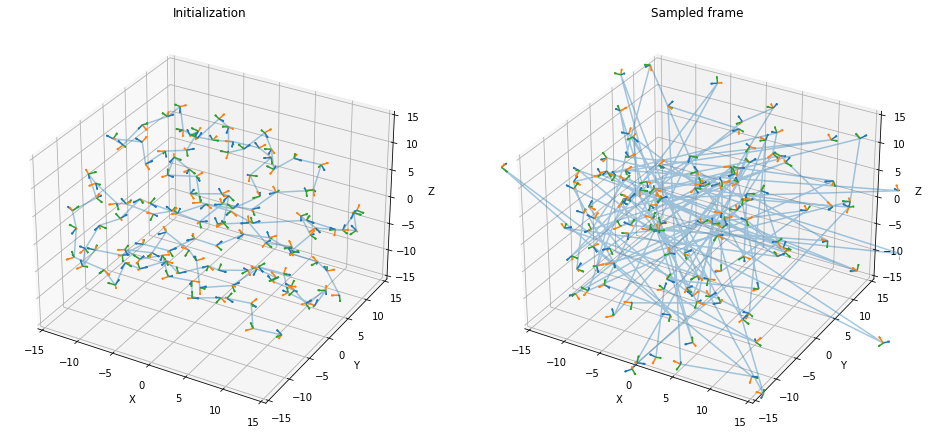

In [35]:
ax_lim = 15
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

## Training

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
chosen_gpu = ''.join(
    [str(x) for x in GPUtil.getAvailable(order='memory')])
os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu

In [ ]:
exp = train_se3_diffusion.Experiment(conf=conf)
logs = exp.train(int(chosen_gpu), 1, return_logs=True)

INFO: Number of model parameters 3488030


Using cached IGSO3.
Using R^3 VP-SDE


INFO: Training: 10 examples
INFO: Validation: 10 examples
INFO: [1]: loss=6.05257, steps/sec=1632.97546
INFO: [1000]: loss=3.81926, steps/sec=96.96886
INFO: [2000]: loss=3.73606, steps/sec=49.02951
INFO: [3000]: loss=3.36843, steps/sec=32.61571
INFO: [6000]: loss=3.06529, steps/sec=111.97999
INFO: [7000]: loss=3.00479, steps/sec=41.01254
INFO: [8000]: loss=2.93718, steps/sec=33.03184
INFO: [9000]: loss=2.87738, steps/sec=20.87847
INFO: [10000]: loss=2.83854, steps/sec=18.76592
INFO: [11000]: loss=2.83172, steps/sec=130.55383
INFO: [12000]: loss=2.73801, steps/sec=54.61125


In [ ]:
logs = exp.train(0, 1, return_logs=True)